### **NIFTY-50 Strong Move Direction Prediction Using Machine Learning**

**This project builds a machine-learning model to predict strong price movements (up or down) for NIFTY 50 stocks for the next trading day.
A strong move is defined as price change exceeding 0.8%.**

### Dataset Creation

Historical OHLCV data from Yahoo Finance is used to generate a feature-rich dataset containing:

* Return-based features (1D, 2D, 3D returns, lag returns)

* Trend indicators (SMA, EMA)

* Momentum indicators (RSI, RSI lag, 10-day momentum)

* Volatility measures (10-day volatility)

* Price-action features (candle body %, range %, volume change %)

* Market-level factors (NIFTY return & volatility)

* Encoded ticker information

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta

# -----------------------------------
# PARAMETERS
# -----------------------------------
THRESHOLD = 0.008  # 0.8% strong move
START = "2010-01-01"

TICKERS = [
    "RELIANCE.NS","HDFCBANK.NS","BHARTIARTL.NS","TCS.NS","ICICIBANK.NS",
    "SBIN.NS","INFY.NS","BAJFINANCE.NS","LT.NS","WIPRO.NS","BAJAJ-AUTO.NS",
    "POWERGRID.NS","NESTLEIND.NS","COALINDIA.NS","TATASTEEL.NS","INDIGO.NS",
    "SBILIFE.NS","TITAN.NS","BAJAJFINSV.NS","ADANIPORTS.NS","NTPC.NS",
    "ONGC.NS","BEL.NS","ADANIENT.NS","JSWSTEEL.NS","ASIANPAINT.NS",
    "EICHERMOT.NS","JIOFIN.NS","GRASIM.NS","HINDALCO.NS","HDFCLIFE.NS",
    "SHRIRAMFIN.NS","TECHM.NS","TRENT.NS","TATAMOTORS.NS","HINDUNILVR.NS",
    "MARUTI.NS","ITC.NS","HCLTECH.NS","SUNPHARMA.NS","KOTAKBANK.NS",
    "AXISBANK.NS","ULTRACEMCO.NS","CIPLA.NS","TATACONSUM.NS","MAXHEALTH.NS",
    "DRREDDY.NS","APOLLOHOSP.NS"
]

final_df = []

print("\n🚀 Building Strong-Move Dataset...\n")

# -----------------------------------
# LOAD NIFTY INDEX
# -----------------------------------
nifty = yf.download("^NSEI", start=START, auto_adjust=False, progress=False)
if isinstance(nifty.columns, pd.MultiIndex):
    nifty.columns = nifty.columns.get_level_values(0)

nifty["NIFTY_Return_1D"] = nifty["Close"].pct_change()
nifty["NIFTY_Vol_10D"] = nifty["NIFTY_Return_1D"].rolling(10).std()
nifty = nifty[["NIFTY_Return_1D","NIFTY_Vol_10D"]]

# -----------------------------------
# PROCESS EACH STOCK
# -----------------------------------
for t in TICKERS:
    print("Downloading:", t)

    df = yf.download(t, start=START, auto_adjust=False, progress=False)
    if df.empty:
        print("Skipping:", t)
        continue

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df = df[["Open","High","Low","Close","Volume"]]

    # FEATURES (old successful set)
    df["Return_1D"] = df["Close"].pct_change()
    df["Return_2D"] = df["Close"].pct_change(2)
    df["Return_3D"] = df["Close"].pct_change(3)

    df["SMA_5"] = df["Close"].rolling(5).mean()
    df["SMA_10"] = df["Close"].rolling(10).mean()
    df["EMA_10"] = ta.ema(df["Close"], length=10)

    df["RSI_14"] = ta.rsi(df["Close"], length=14)
    df["RSI_14_lag1"] = df["RSI_14"].shift(1)
    df["Momentum_10D"] = df["Close"] - df["Close"].shift(10)

    df["Volatility_10D"] = df["Return_1D"].rolling(10).std()

    df["Candle_Body%"] = (df["Close"] - df["Open"]) / df["Open"]
    df["High_Low_Range%"] = (df["High"] - df["Low"]) / df["Close"]
    df["Volume_Change%"] = df["Volume"].pct_change()

    # MERGE NIFTY FEATURES
    df = df.join(nifty, how="left")

    # TARGET: strong move prediction
    df["Tomorrow_Close"] = df["Close"].shift(-1)
    df["Return_Tomorrow"] = (df["Tomorrow_Close"] - df["Close"]) / df["Close"]

    # Filter strong moves
    strong = df[abs(df["Return_Tomorrow"]) > THRESHOLD].copy()

    # Assign final binary target
    strong["Target"] = (strong["Return_Tomorrow"] > 0).astype(int)

    # Add metadata
    strong["Ticker"] = t
    strong["Date"] = strong.index

    final_df.append(strong)

# -----------------------------------
# FINAL MERGE + SAVE
# -----------------------------------
final_df = pd.concat(final_df, ignore_index=True)

# Order columns properly
ordered_cols = [
    "Date", "Ticker",
    "Return_1D","Return_2D","Return_3D",
    "SMA_5","SMA_10","EMA_10",
    "RSI_14","RSI_14_lag1",
    "Momentum_10D","Volatility_10D",
    "Candle_Body%","High_Low_Range%","Volume_Change%",
    "NIFTY_Return_1D","NIFTY_Vol_10D",
    "Target"
]

final_df = final_df[ordered_cols]

final_df.to_csv("NIFTY50_STRONGMOVE_DATASET.csv", index=False)

print("\n✅ Dataset ready! Saved → NIFTY50_STRONGMOVE_DATASET.csv")
print(final_df.head())


🚀 Building Strong-Move Dataset...

Downloading: RELIANCE.NS
Downloading: HDFCBANK.NS
Downloading: BHARTIARTL.NS
Downloading: TCS.NS
Downloading: ICICIBANK.NS
Downloading: SBIN.NS
Downloading: INFY.NS
Downloading: BAJFINANCE.NS
Downloading: LT.NS
Downloading: WIPRO.NS
Downloading: BAJAJ-AUTO.NS
Downloading: POWERGRID.NS
Downloading: NESTLEIND.NS
Downloading: COALINDIA.NS
Downloading: TATASTEEL.NS
Downloading: INDIGO.NS
Downloading: SBILIFE.NS
Downloading: TITAN.NS
Downloading: BAJAJFINSV.NS
Downloading: ADANIPORTS.NS
Downloading: NTPC.NS
Downloading: ONGC.NS
Downloading: BEL.NS
Downloading: ADANIENT.NS
Downloading: JSWSTEEL.NS
Downloading: ASIANPAINT.NS
Downloading: EICHERMOT.NS
Downloading: JIOFIN.NS
Downloading: GRASIM.NS
Downloading: HINDALCO.NS
Downloading: HDFCLIFE.NS
Downloading: SHRIRAMFIN.NS
Downloading: TECHM.NS
Downloading: TRENT.NS
Downloading: TATAMOTORS.NS
Downloading: HINDUNILVR.NS
Downloading: MARUTI.NS
Downloading: ITC.NS
Downloading: HCLTECH.NS
Downloading: SUNPHARMA.N

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics  import accuracy_score
import warnings
warnings.simplefilter('ignore')

In [2]:
stock=pd.read_csv('NIFTY50_STRONGMOVE_DATASET.csv')
stock

,Date,Ticker,Return_1D,Return_2D,Return_3D,SMA_5,SMA_10,EMA_10,RSI_14,RSI_14_lag1,Momentum_10D,Volatility_10D,Candle_Body%,High_Low_Range%,Volume_Change%,NIFTY_Return_1D,NIFTY_Vol_10D,Target
0,2010-01-05,RELIANCE.NS,-0.004463,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,-0.068876,0.078920,-0.720888,0.008734,NaN,1
1,2010-01-06,RELIANCE.NS,0.016158,0.011623,NaN,NaN,NaN,NaN,21.706451,0.000000,NaN,NaN,0.007501,0.021921,0.107463,0.000739,NaN,1
2,2010-01-08,RELIANCE.NS,-0.002622,0.013925,0.030307,248.853931,NaN,NaN,35.841796,37.057738,NaN,NaN,-0.004377,0.016136,-0.423231,-0.003487,NaN,0
3,2010-01-13,RELIANCE.NS,0.003919,0.006565,-0.013189,249.779694,NaN,NaN,33.489217,30.419276,NaN,NaN,0.000551,0.021495,-0.531566,0.004520,NaN,1
4,2010-01-14,RELIANCE.NS,0.030406,0.034445,0.037171,250.495163,NaN,NaN,51.453872,33.489217,NaN,NaN,0.032873,0.034590,0.598004,0.004958,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101380,2025-11-18,APOLLOHOSP.NS,-0.013623,-0.004717,-0.007392,7446.400000,7549.70,7531.708099,32.698940,37.377524,-425.0,0.008119,-0.008658,0.013675,0.147615,-0.003975,0.004290,1
101381,2025-11-25,APOLLOHOSP.NS,-0.003263,-0.008186,-0.012461,7391.600000,7419.00,7434.887691,32.616769,33.723175,-170.5,0.007130,-0.010595,0.012960,-0.684156,-0.002878,0.004524,1
101382,2025-11-26,APOLLOHOSP.NS,0.008526,0.005235,0.000271,7378.400000,7408.50,7427.271747,38.294363,32.616769,-105.0,0.007907,0.007015,0.012647,0.147733,0.012382,0.005549,0
101383,2025-12-02,APOLLOHOSP.NS,-0.006244,-0.012746,-0.010994,7316.100000,7353.85,7351.190146,31.358249,33.507998,-143.5,0.006556,-0.006244,0.009528,0.448899,-0.005484,0.005672,0


In [3]:
stock.shape

(101385, 18)

In [4]:
stock.isnull().sum()

Date                 0
Ticker               0
Return_1D           31
Return_2D           66
Return_3D           97
SMA_5              124
SMA_10             264
EMA_10             264
RSI_14              32
RSI_14_lag1         67
Momentum_10D       289
Volatility_10D     289
Candle_Body%         0
High_Low_Range%      0
Volume_Change%      39
NIFTY_Return_1D    590
NIFTY_Vol_10D      810
Target               0
dtype: int64

In [5]:
stock.duplicated().sum()

np.int64(0)

In [6]:
stock = stock.dropna().reset_index(drop=True)

In [7]:
stock.shape

(100525, 18)

In [8]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100525 entries, 0 to 100524
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date             100525 non-null  object 
 1   Ticker           100525 non-null  object 
 2   Return_1D        100525 non-null  float64
 3   Return_2D        100525 non-null  float64
 4   Return_3D        100525 non-null  float64
 5   SMA_5            100525 non-null  float64
 6   SMA_10           100525 non-null  float64
 7   EMA_10           100525 non-null  float64
 8   RSI_14           100525 non-null  float64
 9   RSI_14_lag1      100525 non-null  float64
 10  Momentum_10D     100525 non-null  float64
 11  Volatility_10D   100525 non-null  float64
 12  Candle_Body%     100525 non-null  float64
 13  High_Low_Range%  100525 non-null  float64
 14  Volume_Change%   100525 non-null  float64
 15  NIFTY_Return_1D  100525 non-null  float64
 16  NIFTY_Vol_10D    100525 non-null  floa

In [9]:
stock.dtypes

Date                object
Ticker              object
Return_1D          float64
Return_2D          float64
Return_3D          float64
SMA_5              float64
SMA_10             float64
EMA_10             float64
RSI_14             float64
RSI_14_lag1        float64
Momentum_10D       float64
Volatility_10D     float64
Candle_Body%       float64
High_Low_Range%    float64
Volume_Change%     float64
NIFTY_Return_1D    float64
NIFTY_Vol_10D      float64
Target               int64
dtype: object

In [10]:
stock.isna().sum()/stock.shape[0]*100

Date               0.0
Ticker             0.0
Return_1D          0.0
Return_2D          0.0
Return_3D          0.0
SMA_5              0.0
SMA_10             0.0
EMA_10             0.0
RSI_14             0.0
RSI_14_lag1        0.0
Momentum_10D       0.0
Volatility_10D     0.0
Candle_Body%       0.0
High_Low_Range%    0.0
Volume_Change%     0.0
NIFTY_Return_1D    0.0
NIFTY_Vol_10D      0.0
Target             0.0
dtype: float64

In [11]:
stock.head()

,Date,Ticker,Return_1D,Return_2D,Return_3D,SMA_5,SMA_10,EMA_10,RSI_14,RSI_14_lag1,Momentum_10D,Volatility_10D,Candle_Body%,High_Low_Range%,Volume_Change%,NIFTY_Return_1D,NIFTY_Vol_10D,Target
0,2010-01-18,RELIANCE.NS,-0.010128,-0.019791,0.010013,251.665509,250.396870,250.117168,42.782128,46.937209,5.486008,0.015054,-0.006775,0.022283,-0.244819,0.004312,0.004904,0
1,2010-01-20,RELIANCE.NS,-0.006912,-0.020009,-0.029935,251.187772,250.483733,249.109788,35.911512,38.100521,-2.400131,0.015004,-0.015982,0.023295,0.479642,-0.000756,0.004957,0
2,2010-01-22,RELIANCE.NS,-0.000190,-0.021949,-0.028710,245.493762,248.168185,246.400090,30.045646,30.090378,-11.269150,0.015005,0.012344,0.039379,1.142221,-0.011415,0.009280,0
3,2010-01-25,RELIANCE.NS,-0.011197,-0.011385,-0.032900,242.867340,247.266425,244.908273,27.452548,30.045646,-9.017609,0.014277,-0.007240,0.016986,-0.664073,-0.005580,0.009125,0
4,2010-01-27,RELIANCE.NS,-0.013915,-0.024956,-0.025141,240.240918,245.968073,243.085068,24.638555,27.452548,-12.983521,0.014430,-0.006238,0.029196,0.854922,-0.030911,0.012363,1


In [12]:
stock.tail()

,Date,Ticker,Return_1D,Return_2D,Return_3D,SMA_5,SMA_10,EMA_10,RSI_14,RSI_14_lag1,Momentum_10D,Volatility_10D,Candle_Body%,High_Low_Range%,Volume_Change%,NIFTY_Return_1D,NIFTY_Vol_10D,Target
100520,2025-11-18,APOLLOHOSP.NS,-0.013623,-0.004717,-0.007392,7446.4,7549.70,7531.708099,32.698940,37.377524,-425.0,0.008119,-0.008658,0.013675,0.147615,-0.003975,0.004290,1
100521,2025-11-25,APOLLOHOSP.NS,-0.003263,-0.008186,-0.012461,7391.6,7419.00,7434.887691,32.616769,33.723175,-170.5,0.007130,-0.010595,0.012960,-0.684156,-0.002878,0.004524,1
100522,2025-11-26,APOLLOHOSP.NS,0.008526,0.005235,0.000271,7378.4,7408.50,7427.271747,38.294363,32.616769,-105.0,0.007907,0.007015,0.012647,0.147733,0.012382,0.005549,0
100523,2025-12-02,APOLLOHOSP.NS,-0.006244,-0.012746,-0.010994,7316.1,7353.85,7351.190146,31.358249,33.507998,-143.5,0.006556,-0.006244,0.009528,0.448899,-0.005484,0.005672,0
100524,2025-12-05,APOLLOHOSP.NS,-0.001597,0.000766,-0.007249,7220.8,7284.00,7279.100388,30.047972,30.593328,-201.5,0.005583,-0.001597,0.010084,-0.150453,0.005865,0.005263,0


In [13]:
stock.columns

Index(['Date', 'Ticker', 'Return_1D', 'Return_2D', 'Return_3D', 'SMA_5',
       'SMA_10', 'EMA_10', 'RSI_14', 'RSI_14_lag1', 'Momentum_10D',
       'Volatility_10D', 'Candle_Body%', 'High_Low_Range%', 'Volume_Change%',
       'NIFTY_Return_1D', 'NIFTY_Vol_10D', 'Target'],
      dtype='object')

In [14]:
stock.describe().T

,count,mean,std,min,25%,50%,75%,max
Return_1D,100525.0,0.000637,0.021476,-0.401513,-0.010314,0.000039,0.011016,2.768717e-01
Return_2D,100525.0,0.001172,0.030279,-0.473671,-0.014853,0.000452,0.016354,3.761366e-01
Return_3D,100525.0,0.001695,0.036953,-0.466425,-0.018020,0.000743,0.020601,4.955662e-01
SMA_5,100525.0,925.997450,1486.134276,2.839154,182.585501,407.763007,1031.115247,1.635240e+04
SMA_10,100525.0,925.045254,1484.085374,2.866018,182.426668,407.420001,1030.134979,1.633580e+04
EMA_10,100525.0,924.963476,1483.773653,2.866798,182.470717,407.676683,1028.262600,1.630922e+04
RSI_14,100525.0,52.018814,12.446460,2.260039,43.362313,52.003274,60.722692,9.583257e+01
RSI_14_lag1,100525.0,52.046374,12.433540,2.264148,43.372679,52.062474,60.730059,9.650723e+01
Momentum_10D,100525.0,3.731733,94.927083,-2225.600098,-11.041672,1.049927,16.549988,1.862000e+03
Volatility_10D,100525.0,0.018489,0.009734,0.002330,0.012311,0.016480,0.022077,1.649027e-01


### EDA

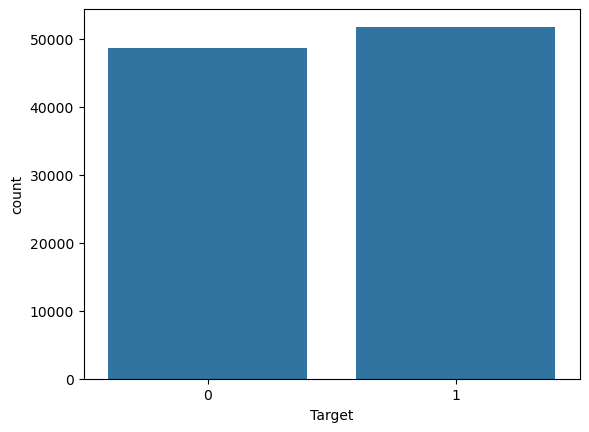

In [15]:
sns.countplot(data=stock,x='Target')
plt.show()

<Axes: >

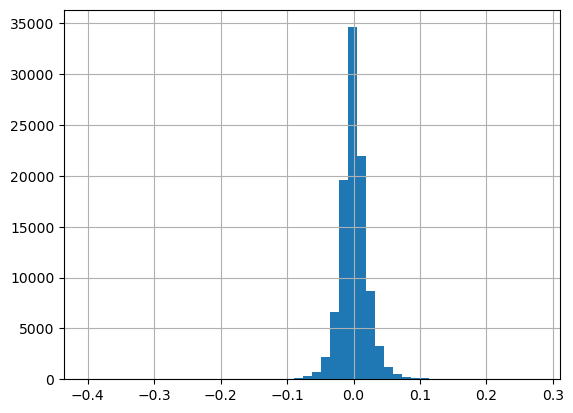

In [16]:
stock['Return_1D'].hist(bins=50)

<Axes: xlabel='Return_1D'>

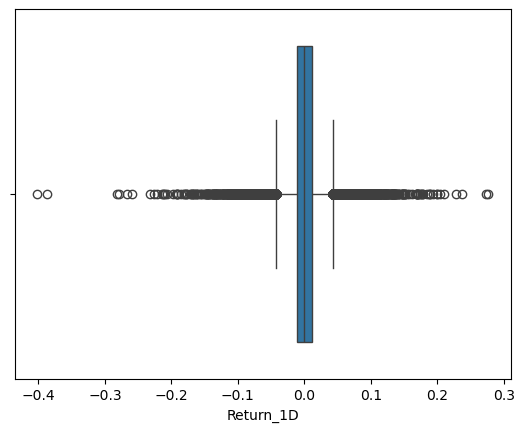

In [19]:
sns.boxplot(x=stock['Return_1D'])

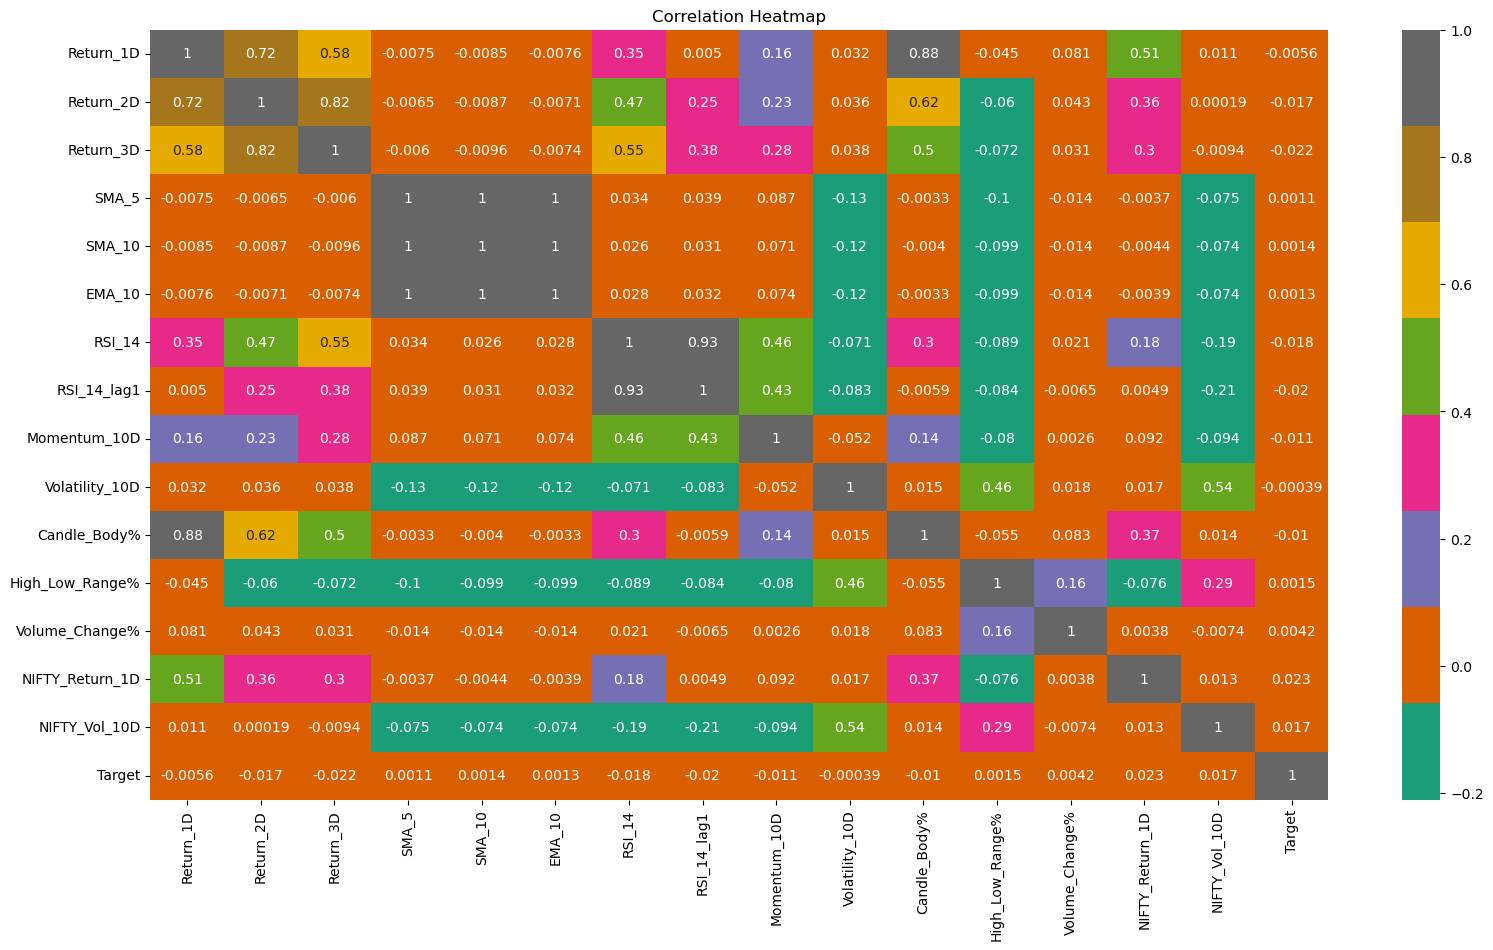

In [40]:
plt.figure(figsize=(19,10))
sns.heatmap(stock.corr(numeric_only=True), annot=True, cmap='Dark2')
plt.title("Correlation Heatmap")
plt.show()

### PREPROCESSING

In [17]:
stock.columns = stock.columns.str.strip()
stock.columns = stock.columns.str.replace(r"\s+", "", regex=True)

In [18]:
stock['Date']=pd.to_datetime(stock['Date'])

In [19]:
stock=stock.sort_values(['Ticker','Date'])
stock=stock.reset_index(drop=True)

In [20]:
stock

,Date,Ticker,Return_1D,Return_2D,Return_3D,SMA_5,SMA_10,EMA_10,RSI_14,RSI_14_lag1,Momentum_10D,Volatility_10D,Candle_Body%,High_Low_Range%,Volume_Change%,NIFTY_Return_1D,NIFTY_Vol_10D,Target
0,2010-01-20,ADANIENT.NS,0.007162,0.003147,-0.008810,73.401892,73.690050,73.333651,72.696617,72.084480,-4.521614,0.030248,-0.003854,0.024469,0.374428,-0.000756,0.004957,0
1,2010-01-21,ADANIENT.NS,-0.021960,-0.014955,-0.018882,72.946666,73.398061,73.032821,67.755310,72.696617,-2.919884,0.028266,-0.005000,0.031648,-0.268482,-0.024427,0.008909,0
2,2010-01-22,ADANIENT.NS,-0.008767,-0.030534,-0.023591,72.368819,72.948965,72.672427,65.872459,67.755310,-4.490959,0.027703,0.001188,0.058246,0.139211,-0.011415,0.009280,0
3,2010-01-25,ADANIENT.NS,-0.019955,-0.028547,-0.049880,71.683679,72.223208,72.119778,61.706257,65.872459,-7.257576,0.026684,-0.001538,0.034669,7.145121,-0.005580,0.009125,0
4,2010-01-29,ADANIENT.NS,-0.003597,-0.004156,-0.024323,69.005963,70.976315,70.299919,56.956665,57.684177,-6.016045,0.009909,0.014302,0.035872,-0.698299,0.003041,0.012008,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100520,2025-11-21,WIPRO.NS,-0.007187,-0.006421,0.014902,244.354001,243.822000,243.776786,52.094187,55.594898,8.000000,0.010830,-0.002082,0.014888,-0.177369,-0.004734,0.004032,1
100521,2025-11-25,WIPRO.NS,-0.006592,0.004704,-0.002518,245.946002,244.960001,244.635205,53.456355,56.705386,3.949997,0.010825,-0.009516,0.016284,-0.584559,-0.002878,0.004524,1
100522,2025-12-02,WIPRO.NS,-0.000440,0.002565,0.002444,249.945999,247.946001,248.020030,59.845460,60.116934,9.270004,0.009988,0.000680,0.010313,1.208208,-0.005484,0.005672,1
100523,2025-12-03,WIPRO.NS,0.018068,0.017620,0.020679,250.845999,248.808000,249.232752,66.533133,59.845460,8.619995,0.009360,0.016321,0.025835,1.016875,-0.001775,0.005417,1


In [21]:
# Replace infinite values
stock = stock.replace([np.inf, -np.inf], np.nan)
stock = stock.dropna().reset_index(drop=True)
print(stock.shape)

(100406, 18)


In [22]:
stock['Ticker']=stock['Ticker'].astype('category')

In [23]:
stock['Ticker_Encoded']=stock['Ticker'].cat.codes

In [24]:
stock

,Date,Ticker,Return_1D,Return_2D,Return_3D,SMA_5,SMA_10,EMA_10,RSI_14,RSI_14_lag1,Momentum_10D,Volatility_10D,Candle_Body%,High_Low_Range%,Volume_Change%,NIFTY_Return_1D,NIFTY_Vol_10D,Target,Ticker_Encoded
0,2010-01-20,ADANIENT.NS,0.007162,0.003147,-0.008810,73.401892,73.690050,73.333651,72.696617,72.084480,-4.521614,0.030248,-0.003854,0.024469,0.374428,-0.000756,0.004957,0,0
1,2010-01-21,ADANIENT.NS,-0.021960,-0.014955,-0.018882,72.946666,73.398061,73.032821,67.755310,72.696617,-2.919884,0.028266,-0.005000,0.031648,-0.268482,-0.024427,0.008909,0,0
2,2010-01-22,ADANIENT.NS,-0.008767,-0.030534,-0.023591,72.368819,72.948965,72.672427,65.872459,67.755310,-4.490959,0.027703,0.001188,0.058246,0.139211,-0.011415,0.009280,0,0
3,2010-01-25,ADANIENT.NS,-0.019955,-0.028547,-0.049880,71.683679,72.223208,72.119778,61.706257,65.872459,-7.257576,0.026684,-0.001538,0.034669,7.145121,-0.005580,0.009125,0,0
4,2010-01-29,ADANIENT.NS,-0.003597,-0.004156,-0.024323,69.005963,70.976315,70.299919,56.956665,57.684177,-6.016045,0.009909,0.014302,0.035872,-0.698299,0.003041,0.012008,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100401,2025-11-21,WIPRO.NS,-0.007187,-0.006421,0.014902,244.354001,243.822000,243.776786,52.094187,55.594898,8.000000,0.010830,-0.002082,0.014888,-0.177369,-0.004734,0.004032,1,47
100402,2025-11-25,WIPRO.NS,-0.006592,0.004704,-0.002518,245.946002,244.960001,244.635205,53.456355,56.705386,3.949997,0.010825,-0.009516,0.016284,-0.584559,-0.002878,0.004524,1,47
100403,2025-12-02,WIPRO.NS,-0.000440,0.002565,0.002444,249.945999,247.946001,248.020030,59.845460,60.116934,9.270004,0.009988,0.000680,0.010313,1.208208,-0.005484,0.005672,1,47
100404,2025-12-03,WIPRO.NS,0.018068,0.017620,0.020679,250.845999,248.808000,249.232752,66.533133,59.845460,8.619995,0.009360,0.016321,0.025835,1.016875,-0.001775,0.005417,1,47


<Axes: xlabel='Target'>

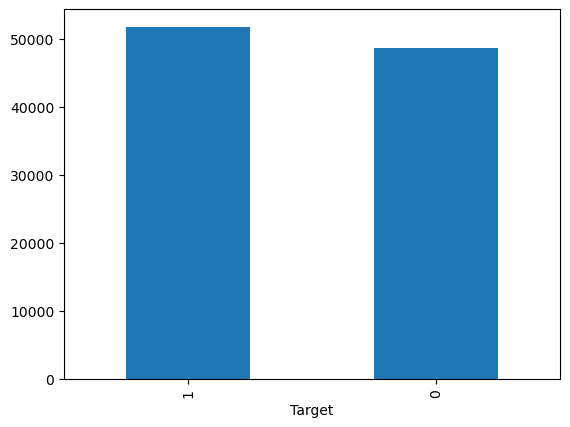

In [25]:
stock['Target'].value_counts().plot(kind='bar')

In [26]:
X=stock.drop(columns=['Date','Target','Ticker'])
y=stock['Target']

In [27]:
X

,Return_1D,Return_2D,Return_3D,SMA_5,SMA_10,EMA_10,RSI_14,RSI_14_lag1,Momentum_10D,Volatility_10D,Candle_Body%,High_Low_Range%,Volume_Change%,NIFTY_Return_1D,NIFTY_Vol_10D,Ticker_Encoded
0,0.007162,0.003147,-0.008810,73.401892,73.690050,73.333651,72.696617,72.084480,-4.521614,0.030248,-0.003854,0.024469,0.374428,-0.000756,0.004957,0
1,-0.021960,-0.014955,-0.018882,72.946666,73.398061,73.032821,67.755310,72.696617,-2.919884,0.028266,-0.005000,0.031648,-0.268482,-0.024427,0.008909,0
2,-0.008767,-0.030534,-0.023591,72.368819,72.948965,72.672427,65.872459,67.755310,-4.490959,0.027703,0.001188,0.058246,0.139211,-0.011415,0.009280,0
3,-0.019955,-0.028547,-0.049880,71.683679,72.223208,72.119778,61.706257,65.872459,-7.257576,0.026684,-0.001538,0.034669,7.145121,-0.005580,0.009125,0
4,-0.003597,-0.004156,-0.024323,69.005963,70.976315,70.299919,56.956665,57.684177,-6.016045,0.009909,0.014302,0.035872,-0.698299,0.003041,0.012008,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100401,-0.007187,-0.006421,0.014902,244.354001,243.822000,243.776786,52.094187,55.594898,8.000000,0.010830,-0.002082,0.014888,-0.177369,-0.004734,0.004032,47
100402,-0.006592,0.004704,-0.002518,245.946002,244.960001,244.635205,53.456355,56.705386,3.949997,0.010825,-0.009516,0.016284,-0.584559,-0.002878,0.004524,47
100403,-0.000440,0.002565,0.002444,249.945999,247.946001,248.020030,59.845460,60.116934,9.270004,0.009988,0.000680,0.010313,1.208208,-0.005484,0.005672,47
100404,0.018068,0.017620,0.020679,250.845999,248.808000,249.232752,66.533133,59.845460,8.619995,0.009360,0.016321,0.025835,1.016875,-0.001775,0.005417,47


In [28]:
y

0         0
1         0
2         0
3         0
4         1
         ..
100401    1
100402    1
100403    1
100404    1
100405    1
Name: Target, Length: 100406, dtype: int64

### TRAIN TEST SPLIT

* We avoid train_test_split() because it randomly shuffles data → causing future leakage.

* Time-series forecasting must always respect chronological order.

* We manually split the dataset using indexing (iloc).

* Training uses the earlier 80% of data, and testing uses the most recent 20%.

* This makes the evaluation realistic and prevents the model from learning future information.

In [29]:
split_idx = int(len(stock) * 0.8)

train = stock.iloc[:split_idx]
test  = stock.iloc[split_idx:]

In [30]:
features = [
    "Return_1D","Return_2D","Return_3D",
    "SMA_5","SMA_10","EMA_10",
    "RSI_14","RSI_14_lag1",
    "Momentum_10D","Volatility_10D",
    "Candle_Body%","High_Low_Range%","Volume_Change%",
    "NIFTY_Return_1D","NIFTY_Vol_10D",
    "Ticker_Encoded"
]

x_train = train[features]
y_train = train["Target"]

x_test = test[features]
y_test = test["Target"]

### Scaling

In [31]:
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)

### LOGISTIC REGRESSION

Test score: 0.5221093516582014
train score: 0.5222224988795379
CR:               precision    recall  f1-score   support

           0       0.51      0.32      0.39      9753
           1       0.53      0.71      0.61     10329

    accuracy                           0.52     20082
   macro avg       0.52      0.52      0.50     20082
weighted avg       0.52      0.52      0.50     20082

Test accuracy: 52.21093516582014
Train accuracy: 52.22224988795379


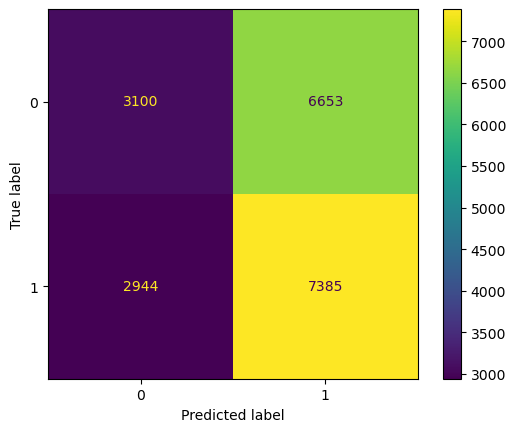

In [32]:
lr=LogisticRegression()
lr.fit(x_train_scaled,y_train)
y_testpred=lr.predict(x_test_scaled)
y_trainpred=lr.predict(x_train_scaled)
print('Test score:',lr.score(x_test_scaled,y_test))
print('train score:',lr.score(x_train_scaled,y_train))
print(ConfusionMatrixDisplay.from_predictions(y_test,y_testpred))
print('CR:',classification_report(y_test,y_testpred))
lrt=accuracy_score(y_test,y_testpred)*100
lrr=accuracy_score(y_train,y_trainpred)*100
print('Test accuracy:',lrt)
print('Train accuracy:',lrr)

### DECISION TREE

Test accuracy: 0.6023802410118514
train accuracy: 1.0
CR:               precision    recall  f1-score   support

           0       0.59      0.60      0.59      9753
           1       0.61      0.61      0.61     10329

    accuracy                           0.60     20082
   macro avg       0.60      0.60      0.60     20082
weighted avg       0.60      0.60      0.60     20082

Test accuracy: 60.23802410118514
Train accuracy: 100.0


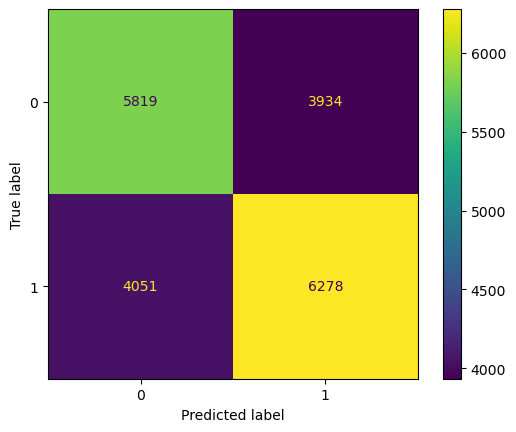

In [36]:
dt=DecisionTreeClassifier(criterion='entropy')
dt.fit(x_train_scaled,y_train)
y_testpred=dt.predict(x_test_scaled)
y_trainpred=dt.predict(x_train_scaled)
print('Test accuracy:',dt.score(x_test_scaled,y_test))
print('train accuracy:',dt.score(x_train_scaled,y_train))
print(ConfusionMatrixDisplay.from_predictions(y_test,y_testpred))
print('CR:',classification_report(y_test,y_testpred))
dtt=accuracy_score(y_test,y_testpred)*100
dtr=accuracy_score(y_train,y_trainpred)*100
print('Test accuracy:',dtt)
print('Train accuracy:',dtr)

### RANDOM FOREST

Test accuracy: 0.5177273179962155
train accuracy: 0.9566754643693043
CR:               precision    recall  f1-score   support

           0       0.50      0.50      0.50      9753
           1       0.53      0.54      0.53     10329

    accuracy                           0.52     20082
   macro avg       0.52      0.52      0.52     20082
weighted avg       0.52      0.52      0.52     20082

Test accuracy: 51.77273179962155
Train accuracy: 95.66754643693042


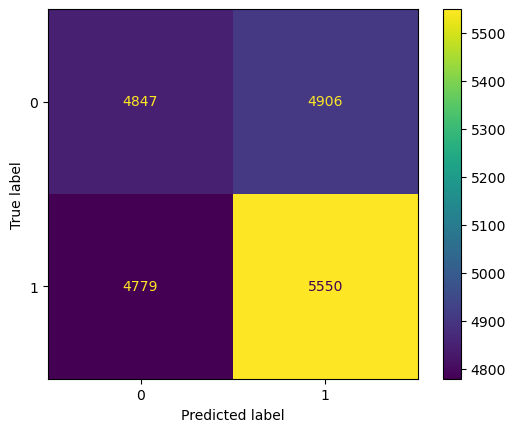

In [37]:
rf=RandomForestClassifier(n_estimators=5,random_state=10)
rf.fit(x_train,y_train)
y_testpred=rf.predict(x_test)
y_trainpred=rf.predict(x_train)
print('Test accuracy:',rf.score(x_test,y_test))
print('train accuracy:',rf.score(x_train,y_train))
print(ConfusionMatrixDisplay.from_predictions(y_test,y_testpred))
print('CR:',classification_report(y_test,y_testpred))
rft=accuracy_score(y_test,y_testpred)*100
rfr=accuracy_score(y_train,y_trainpred)*100
print('Test accuracy:',rft)
print('Train accuracy:',rfr)

### X-G BOOST

Test accuracy: 0.6103475749427348
train accuracy: 0.7553906677954285
CR:               precision    recall  f1-score   support

           0       0.60      0.58      0.59      9753
           1       0.62      0.64      0.63     10329

    accuracy                           0.61     20082
   macro avg       0.61      0.61      0.61     20082
weighted avg       0.61      0.61      0.61     20082

Test accuracy: 61.034757494273485
Train accuracy: 75.53906677954285


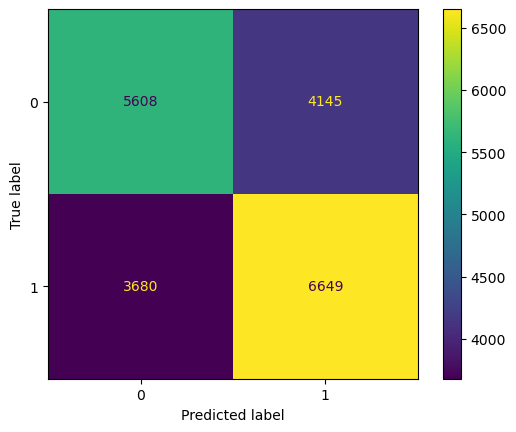

In [33]:
import xgboost as xgb
xg=xgb.XGBClassifier()
xg.fit(x_train, y_train)
y_testpred=xg.predict(x_test)
y_trainpred=xg.predict(x_train)
print('Test accuracy:',xg.score(x_test,y_test))
print('train accuracy:',xg.score(x_train,y_train))
print(ConfusionMatrixDisplay.from_predictions(y_test,y_testpred))
print('CR:',classification_report(y_test,y_testpred))
xgt=accuracy_score(y_test,y_testpred)*100
xgr=accuracy_score(y_train,y_trainpred)*100
print('Test accuracy:',xgt)
print('Train accuracy:',xgr)

### SVM

### KNN

  File "C:\Users\dell\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\dell\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dell\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dell\anaconda3\Lib\subprocess.py",

Test accuracy: 0.5136440593566378
train accuracy: 0.7572456550968577
CR:               precision    recall  f1-score   support

           0       0.50      0.49      0.50      9753
           1       0.53      0.53      0.53     10329

    accuracy                           0.51     20082
   macro avg       0.51      0.51      0.51     20082
weighted avg       0.51      0.51      0.51     20082

Test accuracy: 51.36440593566378
Train accuracy: 75.72456550968577


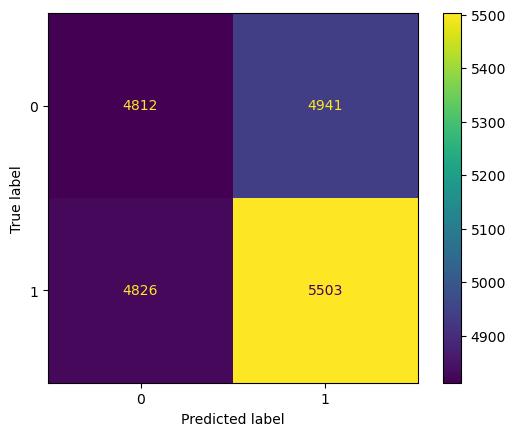

In [39]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_scaled,y_train)
y_testpred=knn.predict(x_test_scaled)
y_trainpred=knn.predict(x_train_scaled)
print('Test accuracy:',knn.score(x_test_scaled,y_test))
print('train accuracy:',knn.score(x_train_scaled,y_train))
print(ConfusionMatrixDisplay.from_predictions(y_test,y_testpred))
print('CR:',classification_report(y_test,y_testpred))
knnt=accuracy_score(y_test,y_testpred)*100
knnr=accuracy_score(y_train,y_trainpred)*100
print('Test accuracy:',knnt)
print('Train accuracy:',knnr)

### NAIVE BAYES

Test accuracy: 0.4951200079673339
train accuracy: 0.49845625217867634
CR:               precision    recall  f1-score   support

           0       0.49      0.85      0.62      9753
           1       0.53      0.16      0.25     10329

    accuracy                           0.50     20082
   macro avg       0.51      0.50      0.43     20082
weighted avg       0.51      0.50      0.43     20082

Test accuracy: 49.51200079673339
Train accuracy: 49.845625217867635


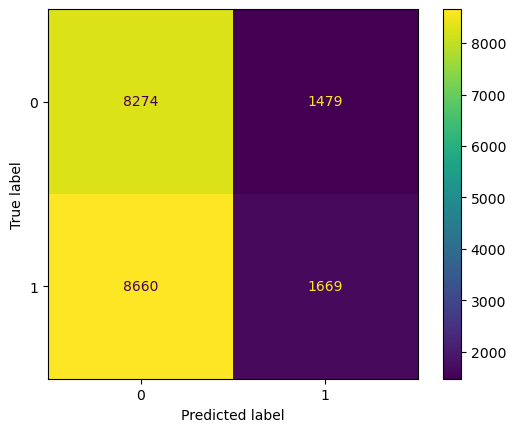

In [40]:
gb=GaussianNB()
gb.fit(x_train_scaled,y_train)
y_testpred=gb.predict(x_test_scaled)
y_trainpred=gb.predict(x_train_scaled)
print('Test accuracy:',gb.score(x_test_scaled,y_test))
print('train accuracy:',gb.score(x_train_scaled,y_train))
print(ConfusionMatrixDisplay.from_predictions(y_test,y_testpred))
print('CR:',classification_report(y_test,y_testpred))
gbt=accuracy_score(y_test,y_testpred)*100
gbr=accuracy_score(y_train,y_trainpred)*100
print('Test accuracy:',gbt)
print('Train accuracy:',gbr)

### ADA BOOST

Test accuracy: 0.5143412010755901
train accuracy: 0.5153129824211942
CR:               precision    recall  f1-score   support

           0       0.00      0.00      0.00      9753
           1       0.51      1.00      0.68     10329

    accuracy                           0.51     20082
   macro avg       0.26      0.50      0.34     20082
weighted avg       0.26      0.51      0.35     20082

Test accuracy: 51.43412010755901
Train accuracy: 51.53129824211942


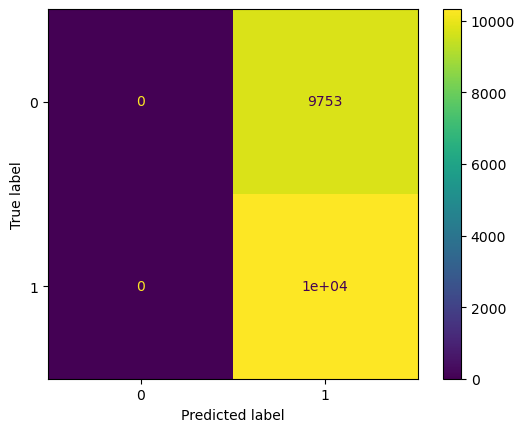

In [41]:
adaboost=AdaBoostClassifier(n_estimators=10,estimator=None,learning_rate=0.2,random_state=5)
adaboost.fit(x_train_scaled,y_train)
y_testpred=adaboost.predict(x_test_scaled)
y_trainpred=adaboost.predict(x_train_scaled)
print('Test accuracy:',adaboost.score(x_test_scaled,y_test))
print('train accuracy:',adaboost.score(x_train_scaled,y_train))
print(ConfusionMatrixDisplay.from_predictions(y_test,y_testpred))
print('CR:',classification_report(y_test,y_testpred))
adt=accuracy_score(y_test,y_testpred)*100
adr=accuracy_score(y_train,y_trainpred)*100
print('Test accuracy:',adt)
print('Train accuracy:',adr)

### GRADIENT BOOSTING

Test accuracy: 0.5525346081067622
train accuracy: 0.5643518749066282
CR:               precision    recall  f1-score   support

           0       0.55      0.45      0.49      9753
           1       0.56      0.65      0.60     10329

    accuracy                           0.55     20082
   macro avg       0.55      0.55      0.55     20082
weighted avg       0.55      0.55      0.55     20082

Test accuracy: 55.25346081067622
Train accuracy: 56.43518749066282


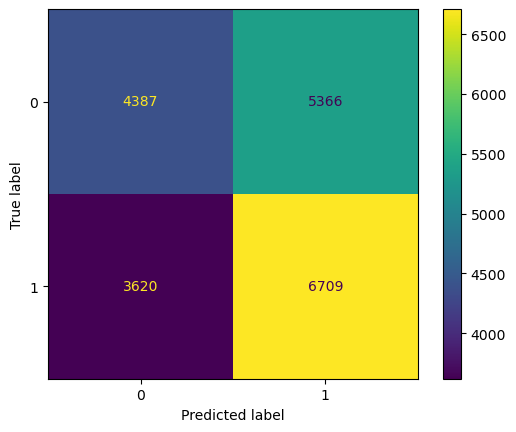

In [42]:
gbc=GradientBoostingClassifier(n_estimators=100,learning_rate=0.05,random_state=200)
gbc.fit(x_train_scaled,y_train)
y_testpred=gbc.predict(x_test_scaled)
y_trainpred=gbc.predict(x_train_scaled)
print('Test accuracy:',gbc.score(x_test_scaled,y_test))
print('train accuracy:',gbc.score(x_train_scaled,y_train))
print(ConfusionMatrixDisplay.from_predictions(y_test,y_testpred))
print('CR:',classification_report(y_test,y_testpred))
gbt=accuracy_score(y_test,y_testpred)*100
gbr=accuracy_score(y_train,y_trainpred)*100
print('Test accuracy:',gbt)
print('Train accuracy:',gbr)

### PERFORMANCE BEFORE TUNING

In [49]:
tb=pd.DataFrame()
tb['model']=pd.Series(['knn','lr','gb','rf','adaboost','gbc','dt','xg','SVM'])
tb['test_accuracy']=pd.Series([knnt,lrt,gbt,rft,adt,gbt,dtt,xgt,'slow'])
tb['train_accuracy']=pd.Series([knnr,lrr,gbr,rfr,adr,gbr,dtr,xgr,'slow'])
tb

,model,test_accuracy,train_accuracy
0,knn,51.364406,75.724566
1,lr,52.210935,52.22225
2,gb,55.253461,56.435187
3,rf,51.772732,95.667546
4,adaboost,51.43412,51.531298
5,gbc,55.253461,56.435187
6,dt,60.238024,100.0
7,xg,61.034757,75.539067
8,SVM,slow,slow


### HYPERPARAMETER TUNING

In [43]:
##DECISION TREE
dt_params = {
    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

dt_grid=GridSearchCV(DecisionTreeClassifier(random_state=42),dt_params,cv=5)
dt_grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10, 20]})

In [54]:
print("Best RF Params:", dt_grid.best_params_)
print("Best RF Accuracy:", dt_grid.best_score_)

best_rf = dt_grid.best_estimator_

Best RF Params: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best RF Accuracy: 0.540971554956644


In [35]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
##RANDOM FOREST
rf_params = {
    "n_estimators": [200, 300, 400],
    "max_depth": [4, 6, 8, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True, False]
}
rf = RandomForestClassifier(random_state=42)
rf_grid = RandomizedSearchCV(estimator=rf,param_distributions=rf_params,n_iter=25,scoring="accuracy",cv=5,verbose=1,random_state=42,n_jobs=-1)
rf_grid.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [58]:
print("Best RF Params:", rf_grid.best_params_)
print("Best RF Accuracy:", rf_grid.best_score_)

best_rf = rf_grid.best_estimator_

Best RF Params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
Best RF Accuracy: 0.6002184903399164


In [ ]:
##Gradient boosting
gb_params = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4, 5],
    "subsample": [0.6, 0.8, 1.0],
    "min_samples_split": [2, 5, 10]
}
gb = GradientBoostingClassifier(random_state=42)
gb_grid = RandomizedSearchCV(estimator=gb,param_distributions=gb_params,n_iter=25,scoring="accuracy",cv=3,verbose=1,random_state=42,n_jobs=-1)
gb_grid.fit(x_train_scaled, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [ ]:
print("Best GB Accuracy:", gb_grid.best_score_)
print("Best GB Params:", gb_grid.best_params_)
best_gb = gb_random.best_estimator_

In [36]:
##XG-BOOST
param_grid = {
    "n_estimators": [200, 300, 400,500],
    "max_depth": [3, 5, 7,6],
    "learning_rate": [0.01, 0.05, 0.1,0.03],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 1.0],
    "min_child_weight": [1, 3,5],
    "gamma": [0, 0.1]
}
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)
xgb_grid = RandomizedSearchCV(
    xgb, param_grid,
    n_iter=25,
    cv=5,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    random_state=42
)
xgb_grid.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 1.0],
                                        'gamma': [0, 0.1],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.03],
                                        'max_depth': [3, 5, 7, 6],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [200, 300, 400, 500],
                                        'subsample': [0.7, 0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [38]:
print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB Accuracy:", xgb_grid.best_score_)

best_xgb = xgb_grid.best_estimator_

Best XGB Params: {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Best XGB Accuracy: 0.6001937914386649


In [39]:
y_pred = best_xgb.predict(x_test)

print("Tuned Test Accuracy:", accuracy_score(y_test, y_pred))
print("Tuned Train Accuracy:", accuracy_score(y_train, best_xgb.predict(x_train)))

Tuned Test Accuracy: 0.6131361418185439
Tuned Train Accuracy: 0.7893406702853444


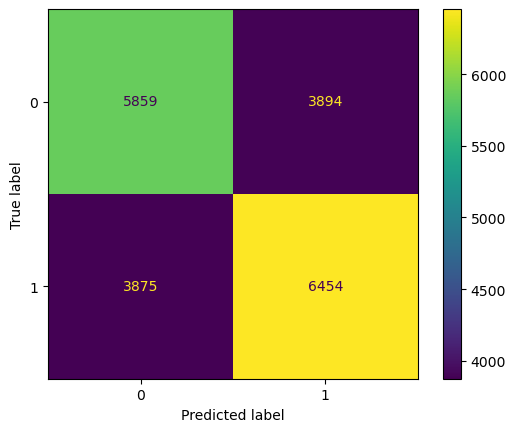

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


In [41]:
print('CR:',classification_report(y_test,y_pred))

CR:               precision    recall  f1-score   support

           0       0.60      0.60      0.60      9753
           1       0.62      0.62      0.62     10329

    accuracy                           0.61     20082
   macro avg       0.61      0.61      0.61     20082
weighted avg       0.61      0.61      0.61     20082



<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

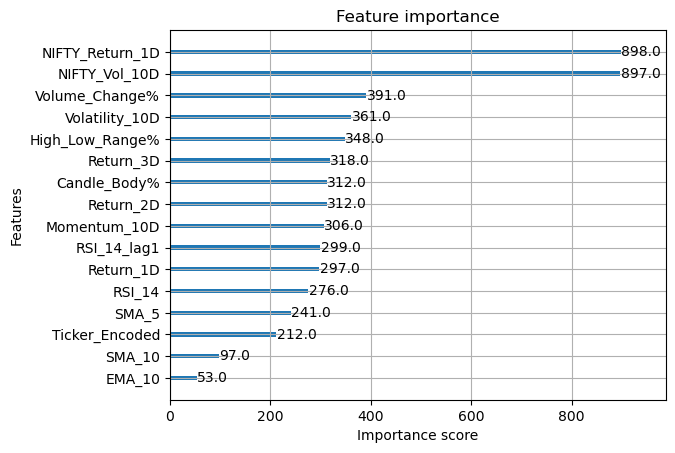

In [42]:
import xgboost as xgb
xgb.plot_importance(xg)

In [68]:
import joblib

joblib.dump(best_xgb,"StrongMove_XGB_Model.pkl")


['StrongMove_XGB_Model.pkl']

In [69]:
joblib.dump(features,'features.pkl')

['features.pkl']

In [71]:
import pickle

In [72]:
ticker_categories = stock["Ticker"].astype("category").cat.categories
pickle.dump(ticker_categories, open("ticker_categories.pkl", "wb"))

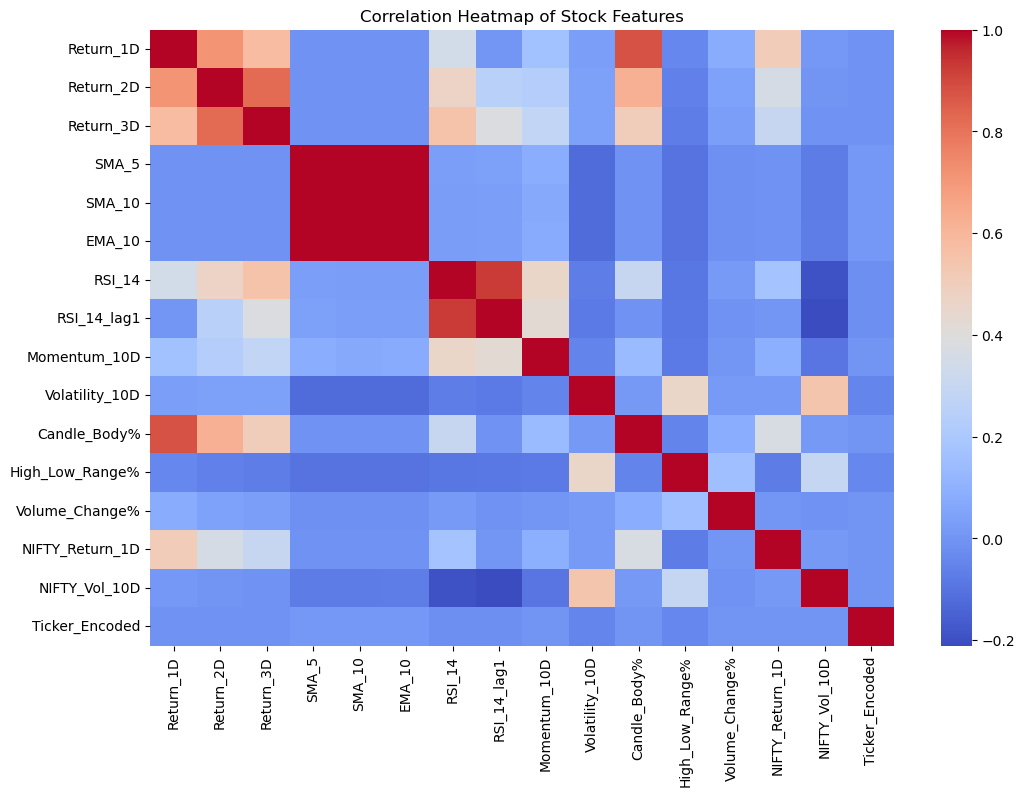

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(stock[features].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Stock Features")
plt.show()